In [404]:
import os
import re
from glob import glob
from importlib import reload

from collections import OrderedDict

import numpy as np

from astropy import units as u
from astropy import coordinates
from astropy.coordinates import SkyCoord, UnitSphericalRepresentation
from astropy import table

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
# a fun trick that makes the notebook always be 95% of the browser window
from IPython.core.display import HTML
HTML("<style>.container { width:95% !important; }</style>")

# First parse/load the data 

In [4]:
import data_loaders

In [5]:
elvii_pairs = data_loaders.load_elvii(isolated=False)

Loading /Users/erik/projects/m31-galfa/elvis_data/Burr&Hamilton.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/Charybdis&Scylla.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/Cher&Sonny.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/Hall&Oates.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/Kauket&Kek.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/Lincoln&Douglas.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/Romulus&Remus.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/Siegfried&Roy.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/Taurus&Orion.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/Thelma&Louise.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/Venus&Serana.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/Zeus&Hera.txt


In [6]:
#m31 = SkyCoord.from_name('M31')
m31 = SkyCoord(10.6847083*u.deg, 41.26875*u.deg, 700*u.kpc)

In [7]:
res = data_loaders.load_galfa_sensitivity('onempc_mass_sens.fits.zip')
galfa_sens, galfa_sens_scs, galfa_sens_wcs, galfa_sens_hdu = res

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/coordinates/angles.py:672: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/coordinates/angles.py:672: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/coordinates/angles.py:563: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/coordinates/angles.py:563: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):


# Now some LG-simulating behavior

First we produce $M_{HI}$ for everything following Bradford+15

In [8]:
def bradford_15_mstar_to_mgas(mstar):
    logx = np.log10(mstar/u.Msun)
    faintmsk = logx < 8.6
    mgas = np.empty_like(logx)
    mgas[faintmsk] = 1.052 *logx[faintmsk] + 0.236
    mgas[~faintmsk] = 0.461 *logx[~faintmsk] + 5.329
    return u.solMass*10**mgas

In [9]:
# produce HI masses for each table
for tab in elvii_pairs.values():
    Ms = tab['Mstar_preferred']
    tab['MHI'] = bradford_15_mstar_to_mgas(Ms)

Now we populate the tables with coordinates for an artificial "LG"

In [10]:
for tab in elvii_pairs.values():
    #these add host{n}_lat/host{n}_lon/host{n}_dist
    data_loaders.add_oriented_radecs(tab, 0, 1, target_coord=m31)
    data_loaders.add_oriented_radecs(tab, 1, 0, target_coord=m31)

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/coordinates/angles.py:736: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if axis == 'z':
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/coordinates/angles.py:740: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif axis == 'y':
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/coordinates/angles.py:744: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif axis == 'x':
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/units/quantity.py:866: RuntimeWarning: divide by zero encountered in power
  return super(Quantity, self).__pow__(other)
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astro

Now we pull the sensitivity from the GALFA image

In [11]:
for tab in elvii_pairs.values():
    for i in (0, 1):
        host_sc = SkyCoord(ra=tab['host{}_lon'.format(i)], 
                           dec=tab['host{}_lat'.format(i)])
        
        pxs = host_sc.to_pixel(galfa_sens_wcs)
        xp = np.round(pxs[0]).astype(int)
        yp = np.round(pxs[1]).astype(int)
        msk = (0<=xp)&(xp<galfa_sens.shape[0])&(0<=yp)&(yp<galfa_sens.shape[1])
        
        sens = np.zeros(len(tab), dtype=galfa_sens.dtype)*galfa_sens.unit
        sens[msk] = galfa_sens[xp[msk], yp[msk]]
        sens[sens==0] = np.inf
        
        tab['closest_sens{}'.format(i)] = sens

And then see if the line is detectable

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


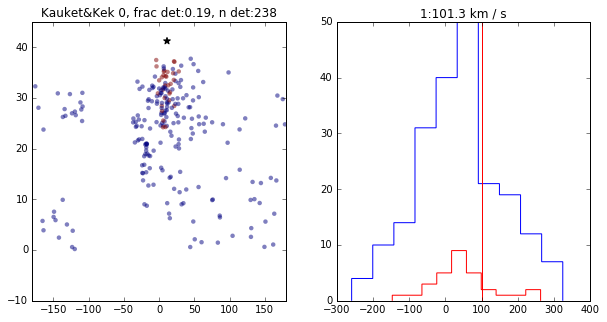

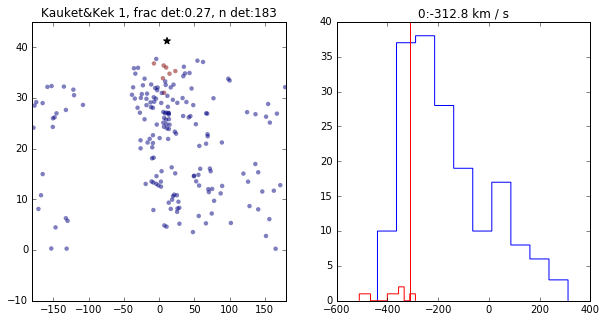

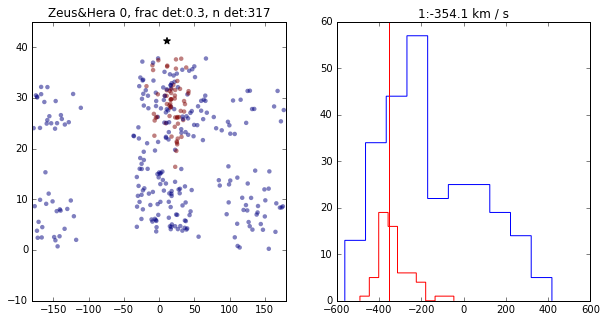

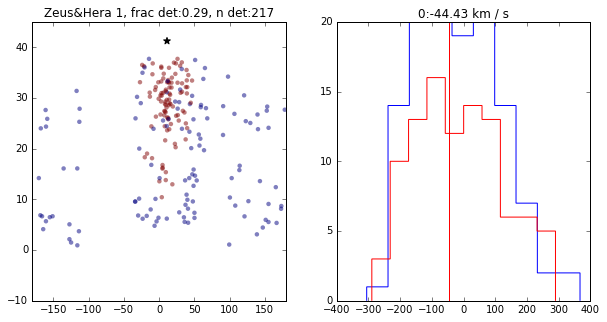

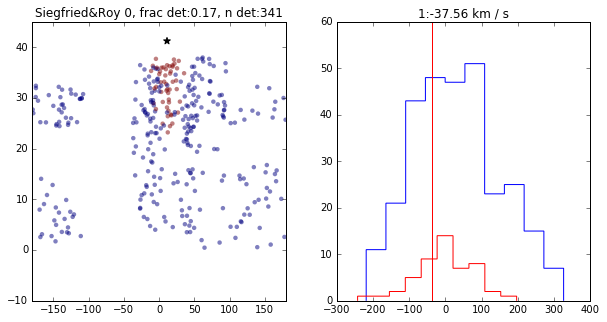

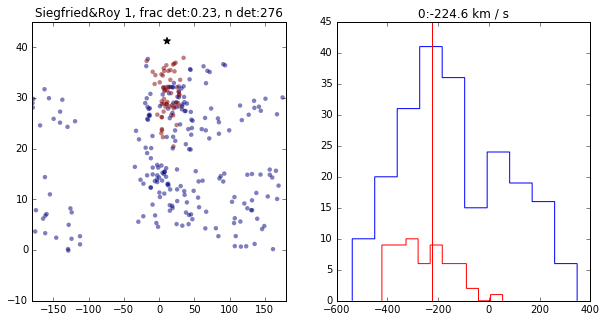

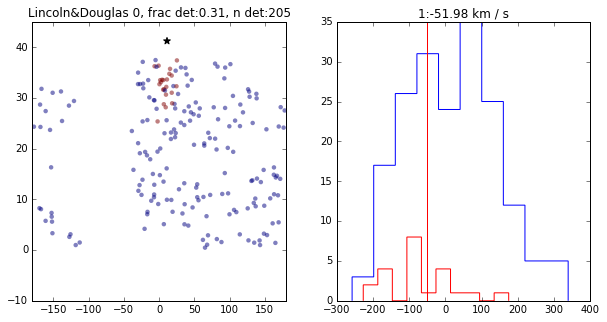

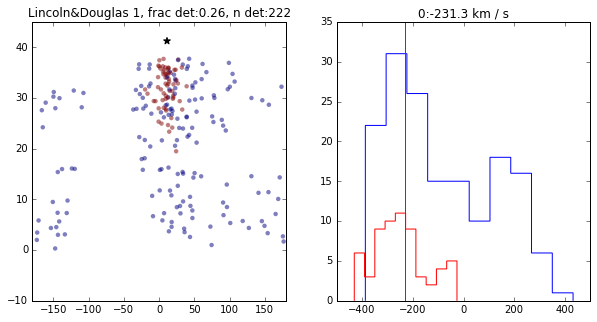

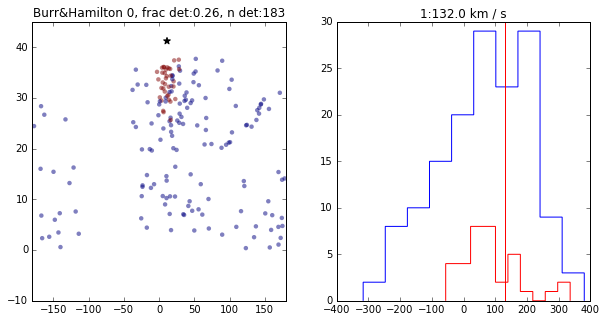

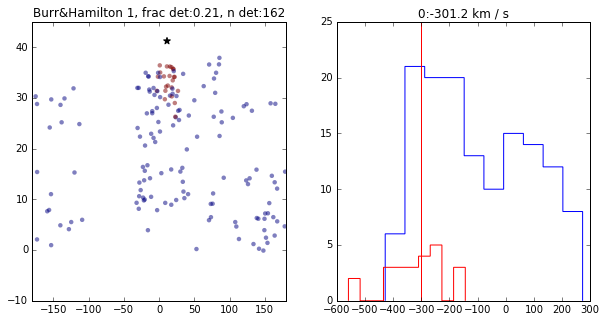

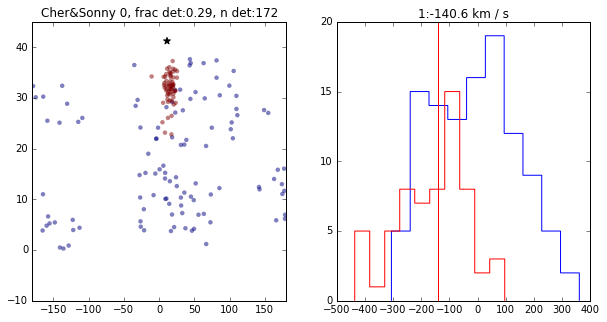

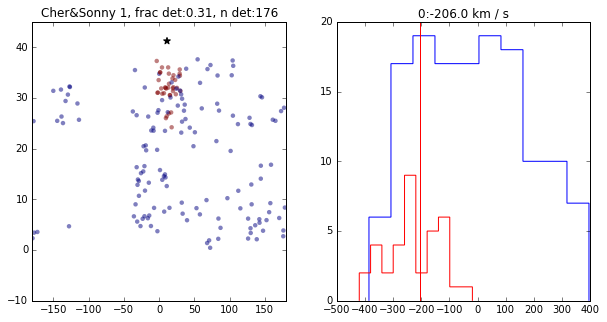

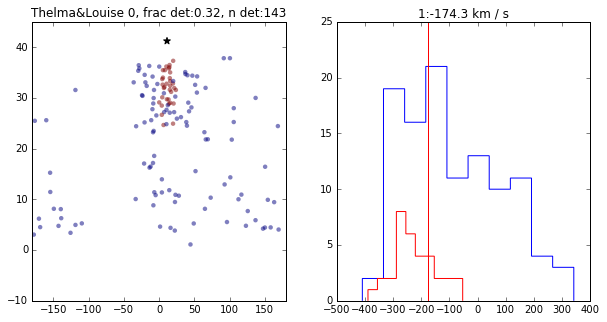

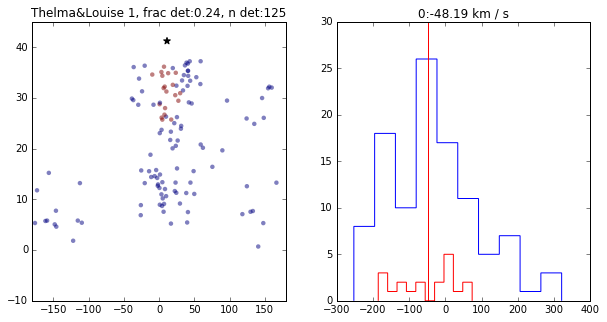

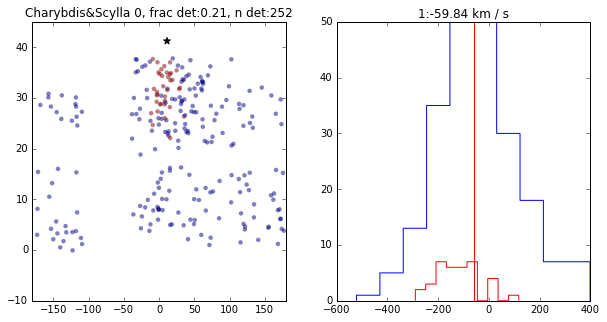

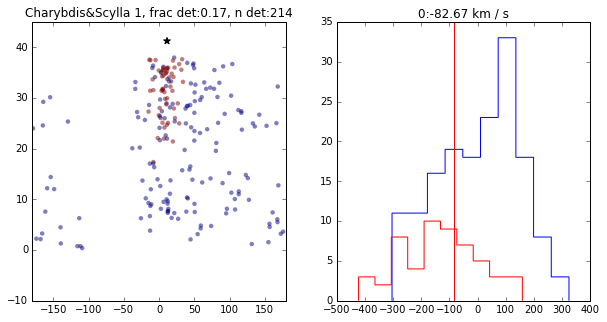

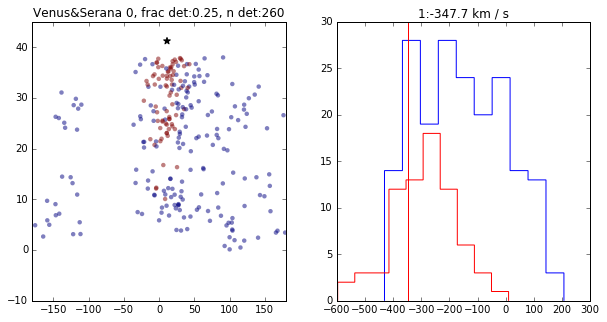

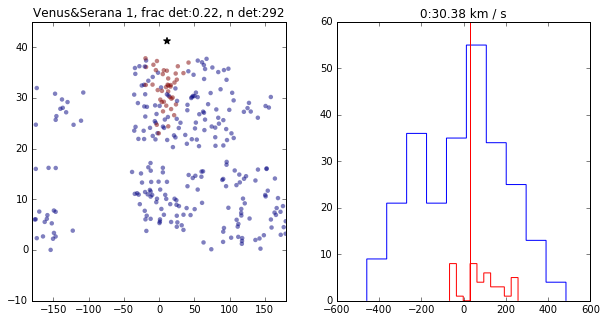

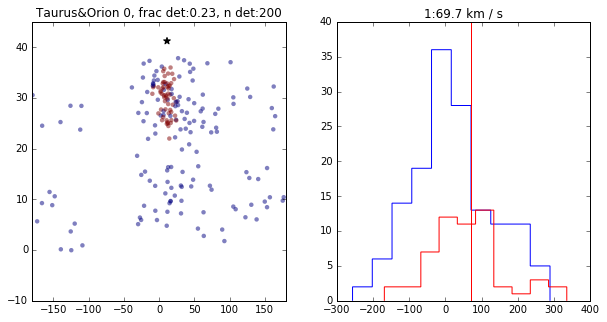

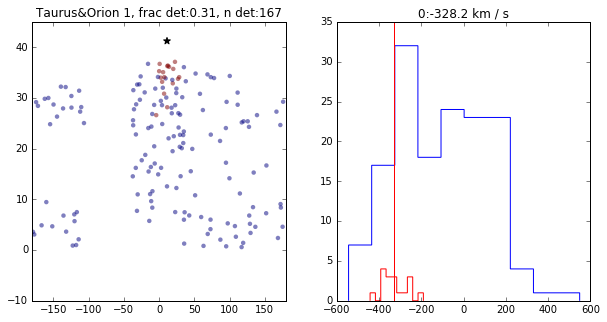

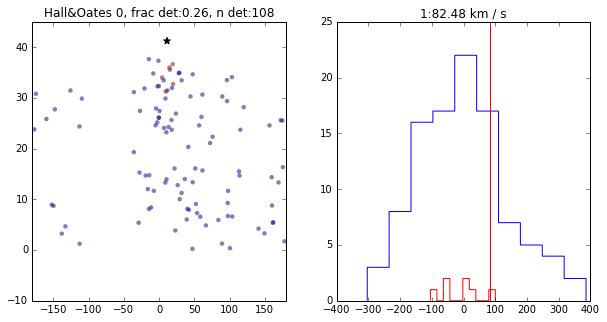

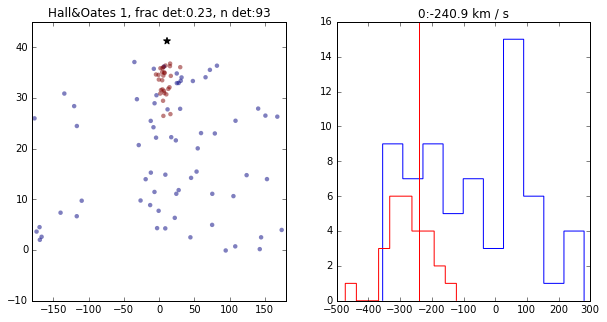

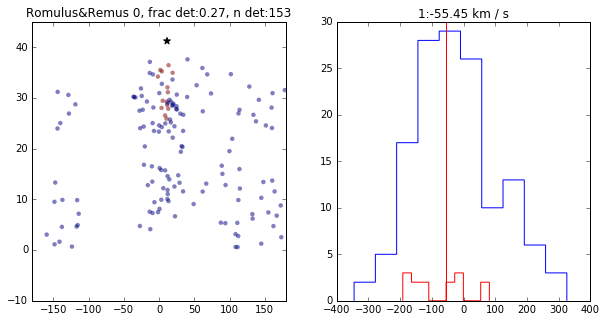

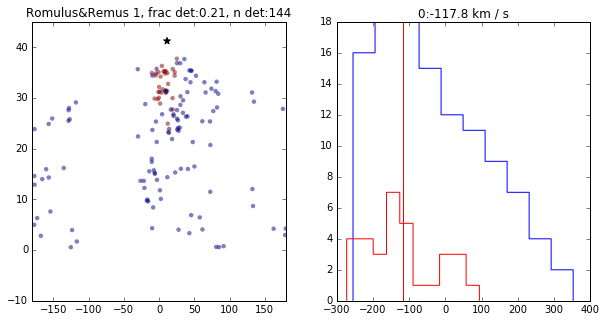

In [12]:
for name, tab in elvii_pairs.items():
    MHI = tab['MHI']
    for i in (0, 1):
        sens = tab['closest_sens{}'.format(i)]
        det = sens*tab['host{}_dist'.format(i)]**2 < MHI
        tab['detectable{}'.format(i)] = det
        
        fracdet = np.sum(det)/np.sum(np.isfinite(sens))
        
        ra = tab['host{}_lon'.format(i)]
        dec = tab['host{}_lat'.format(i)]
        
        otheridx = 1 if i==0 else 0
        x, y, z = tab['X'], tab['Y'], tab['Z']
        dother = ((x-x[otheridx])**2+(y-y[otheridx])**2+(z-z[otheridx])**2)**0.5
        inrvir = dother < tab['Rvir'][otheridx]
        
        plt.figure(figsize=(10, 5))
        
        plt.subplot(1,2, 1)
        plt.scatter(ra[det].wrap_at(180*u.deg).deg, dec[det].deg, c=inrvir[det],lw=0, alpha=.5)
        plt.scatter(ra[otheridx].wrap_at(180*u.deg).deg, dec[otheridx].deg, color='k', alpha=1, marker='*', s=50)
        plt.title('{} {}, frac det:{:.2}, n det:{}'.format(name, i, fracdet, np.sum(det)))
        plt.xlim(-180, 180)
        plt.ylim(-10, 45)
        
        plt.subplot(1,2, 2)
        vr = tab['host{}_vrlsr'.format(i)]
        plt.hist(vr[det&~inrvir].value, color='b', histtype='step')
        plt.hist(vr[det&inrvir].value, color='r', histtype='step')
        plt.axvline(vr[otheridx].value, c='r')
        plt.title('{}:{:.4}'.format(otheridx, vr[otheridx]))

In [13]:
for name, tab in elvii_pairs.items():
    dx = tab['X'][1] - tab['X'][0]
    dy = tab['Y'][1] - tab['Y'][0]
    dz = tab['Z'][1] - tab['Z'][0]
    d = (dx**2 + dy**2 + dz**2)**0.5
    
    dvx = tab['Vx'][1] - tab['Vx'][0]
    dvy = tab['Vy'][1] - tab['Vy'][0]
    dvz = tab['Vz'][1] - tab['Vz'][0]
    vsep = (dvx*dx + dvy*dy + dvz*dz)/d
    
    print(name , '{:.4}'.format(d.to(u.kpc)), '{:.4}'.format(vsep.to(u.km/u.s)))

Kauket&Kek 1.04e+03 kpc -106.1 km / s
Zeus&Hera 595.2 kpc -200.7 km / s
Siegfried&Roy 877.6 kpc -130.8 km / s
Lincoln&Douglas 780.4 kpc -142.0 km / s
Burr&Hamilton 941.3 kpc -84.83 km / s
Cher&Sonny 966.2 kpc -173.5 km / s
Thelma&Louise 832.2 kpc -111.5 km / s
Charybdis&Scylla 705.1 kpc -71.16 km / s
Venus&Serana 687.4 kpc -157.8 km / s
Taurus&Orion 829.3 kpc -128.7 km / s
Hall&Oates 979.5 kpc -78.48 km / s
Romulus&Remus 935.4 kpc -86.78 km / s


# Tests of LSR effects and roll-importance

In [157]:
def coo_to_scatter_inputs(coo):
    x = coo.spherical.lon.wrap_at(180*u.deg).rad
    y = coo.spherical.lat.rad
    return np.atleast_1d(x), np.atleast_1d(y)

# Working test of spatial orientation 

In [611]:
reload(data_loaders)

nroll = 10

newtabs = OrderedDict()
for tab in elvii_pairs.values():
    for roll in np.linspace(0, 360, nroll, False)*u.deg:
        newtabs[roll] = newtab = tab.copy()
        data_loaders.add_oriented_radecs(newtab, 0, 1, target_coord=m31, roll_angle=roll)
        data_loaders.add_oriented_radecs(newtab, 1, 0, target_coord=m31, roll_angle=roll)
    break

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/units/quantity.py:763: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return super(Quantity, self).__eq__(other)


In [612]:
sc0 = SkyCoord(newtab['host0_lon'],newtab['host0_lat'],distance=newtab['host0_dist'])
sc1 = SkyCoord(newtab['host1_lon'],newtab['host1_lat'],distance=newtab['host1_dist'])

#these should all be the same for the assumptions to hold right
data_loaders.galactic_center.separation(m31), sc0[0].separation(sc0[1]), sc1[0].separation(sc1[1])

(<Angle 118.77568035668436 deg>,
 <Angle 118.77568035668433 deg>,
 <Angle 118.77568035668433 deg>)

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/matplotlib/projections/geo.py:394: RuntimeWarning: invalid value encountered in sqrt
  z = np.sqrt(1.0 - quarter_x*quarter_x - half_y*half_y)


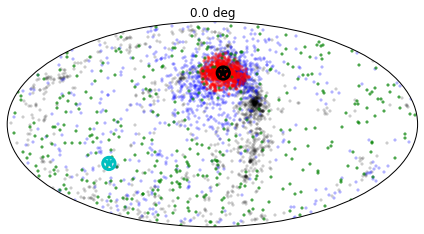

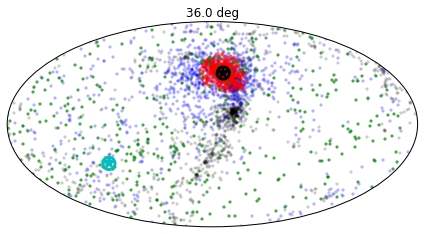

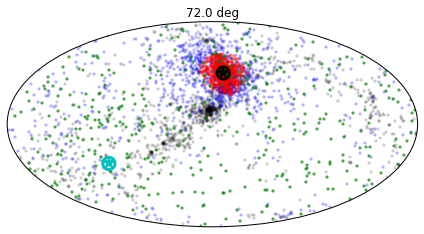

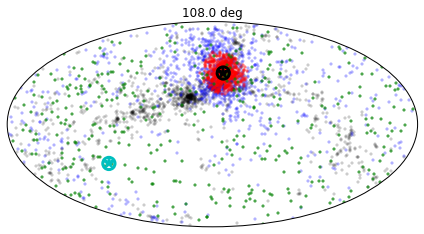

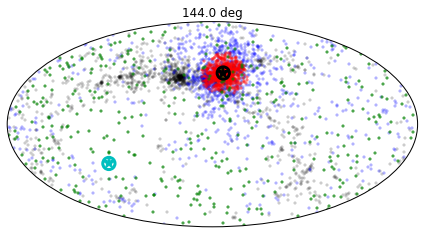

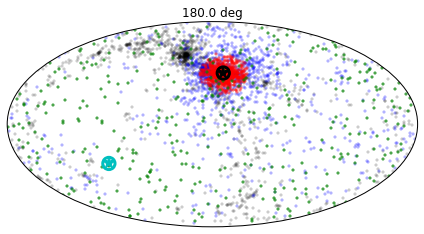

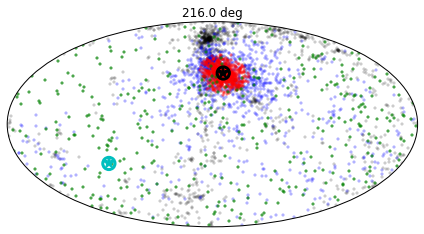

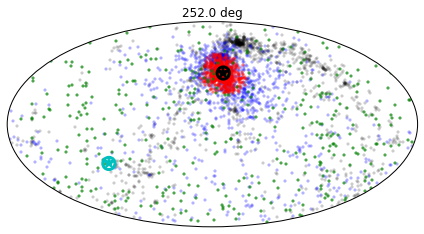

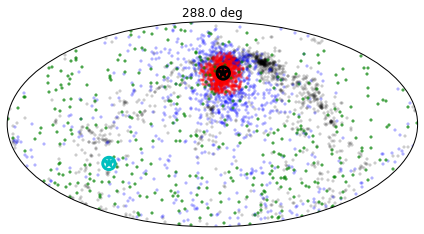

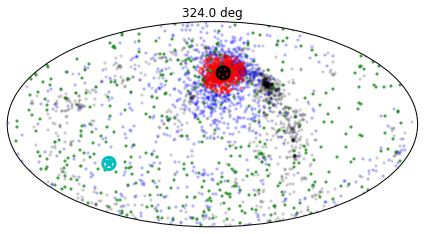

In [729]:
for roll, newtab in newtabs.items():
    sc0 = SkyCoord(newtab['host0_lon'],newtab['host0_lat'],distance=newtab['host0_dist'])
    sc1 = SkyCoord(newtab['host1_lon'],newtab['host1_lat'],distance=newtab['host1_dist'])
    near1 = newtab['host1_dist']<newtab['Rvir'][1]
    near0 = newtab['host0_dist']<newtab['Rvir'][0]
    nearish = (newtab['host0_dist']<.7*u.Mpc)|(newtab['host1_dist']<.7*u.Mpc)

    plt.figure()
    plt.subplot(projection='hammer')
    
    msk0 = ~(near1|near0|nearish)
    msk2 = near1
    msk3 = near0
    msk1 = ~(msk0|msk2|msk3)

    plt.scatter(*coo_to_scatter_inputs(sc0[msk0]), c='k',s=10, alpha=.2, lw=0)
    plt.scatter(*coo_to_scatter_inputs(sc0[msk1]), c='b',s=10, alpha=.3, lw=0)
    plt.scatter(*coo_to_scatter_inputs(sc0[msk2]), c='r',s=10, alpha=.5, lw=0)
    plt.scatter(*coo_to_scatter_inputs(sc0[msk3]), c='g',s=10, alpha=.7, lw=0)

    plt.scatter(*coo_to_scatter_inputs(data_loaders.galactic_center.icrs), color='c', marker='*', s=150)
    plt.scatter(*coo_to_scatter_inputs(m31.icrs), color='k', marker='*', s=150)


    plt.scatter(*coo_to_scatter_inputs(sc0[0]), edgecolors='c', marker='o', s=150, lw=3, c='none')
    plt.scatter(*coo_to_scatter_inputs(sc0[1]), edgecolors='k', marker='o', s=150, lw=3, c='none')

    plt.xticks([])
    plt.yticks([])
    plt.title(str(roll))
    plt.tight_layout()

In [723]:
%matplotlib nbagg

<IPython.core.display.Javascript object>


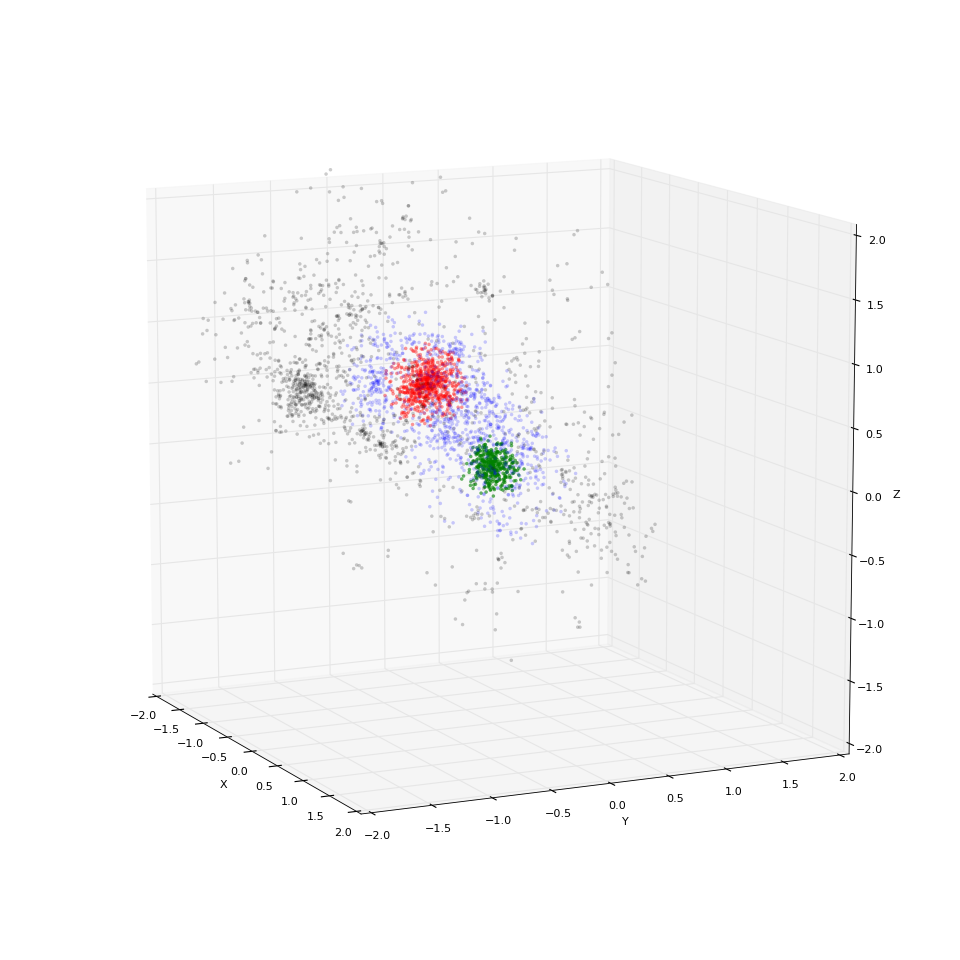

In [724]:
newtab = newtabs[0*u.deg]
near0 = newtab['host0_dist']<newtab['Rvir'][0]
near1 = newtab['host1_dist']<newtab['Rvir'][1]
nearish = (newtab['host0_dist']<.7*u.Mpc)|(newtab['host1_dist']<.7*u.Mpc)

dx = newtab['X']-newtab['X'][0]
dy = newtab['Y']-newtab['Y'][0]
dz = newtab['Z']-newtab['Z'][0]

plt.figure(figsize=(12, 12))
ax = plt.subplot(projection='3d')

msk0 = ~(near1|near0|nearish)
msk2 = near1
msk3 = near0
msk1 = ~(msk0|msk2|msk3)

ax.scatter3D(dx[msk0], dy[msk0], dz[msk0], c='k',s=10, alpha=.2, lw=0)
ax.scatter3D(dx[msk1], dy[msk1], dz[msk1], c='b',s=10, alpha=.2, lw=0)
ax.scatter3D(dx[msk2], dy[msk2], dz[msk2], c='r',s=10, alpha=.4, lw=0)
ax.scatter3D(dx[msk3], dy[msk3], dz[msk3], c='g',s=10, alpha=.6, lw=0)

ax.set_xlim3d(-2, 2.)
ax.set_ylim3d(-2, 2.)
ax.set_zlim3d(-2.,2.)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.tight_layout()

In [726]:
%matplotlib inline

## First map out where M31 is in the LSR frame 

In [49]:
n = 1000
lat = np.arcsin(2*np.random.rand(n)-1)*u.radian
lon  = np.random.rand(n)*360*u.deg

usr = UnitSphericalRepresentation(lat=lat, lon=lon)
cart = usr.to_cartesian()

394

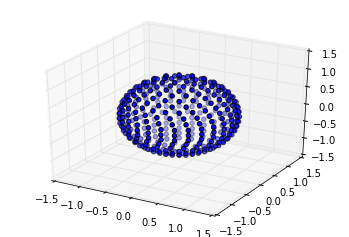

In [113]:
# first map out a roll-less grid of velocities
ntopring = 4
nlats = 21

ringlats = np.linspace(-90, 90, nlats+2)[1:-1]*u.deg
eqnum = ntopring/np.cos(ringlats[0])

lats = []
lons = []
for l in ringlats.to(u.deg):
    n = int(np.round(eqnum*np.cos(l)))
    lons.extend(np.linspace(0, 360, n, False))
    lats.extend([l.value]*n)
    
lats = lats*u.deg
lons = lons*u.deg

# this plots the above in 3D to make sure it's evenly sampled
rep = UnitSphericalRepresentation(lons, lats).to_cartesian()

fig = plt.figure()
ax = plt.subplot(projection='3d')
ax.scatter3D(rep.x, rep.y, rep.z)

lats.size

In [137]:
# velocities in the LSR converted to a galactic-fixed frame
vrot = 220*u.km/u.s

sc = SkyCoord(rep, frame='galactic')
vr = sc.cartesian.y*vrot

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/matplotlib/projections/geo.py:394: RuntimeWarning: invalid value encountered in sqrt
  z = np.sqrt(1.0 - quarter_x*quarter_x - half_y*half_y)


([], <a list of 0 Text xticklabel objects>)

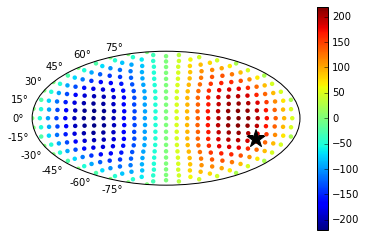

In [171]:
ax = plt.subplot(projection='hammer')
scat = ax.scatter(*coo_to_scatter_inputs(sc), c=vr, lw=0)
plt.colorbar(scat)

ax.scatter(*coo_to_scatter_inputs(m31.galactic), c='k', marker='*', s=350)

plt.xticks([])

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/matplotlib/projections/geo.py:394: RuntimeWarning: invalid value encountered in sqrt
  z = np.sqrt(1.0 - quarter_x*quarter_x - half_y*half_y)


([], <a list of 0 Text xticklabel objects>)

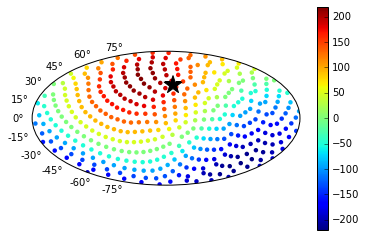

In [170]:
ax = plt.subplot(projection='hammer')
scat = ax.scatter(*coo_to_scatter_inputs(sc.icrs), c=vr, lw=0)
plt.colorbar(scat)

ax.scatter(*coo_to_scatter_inputs(m31.icrs), c='k', marker='*', s=350)

plt.xticks([])